## Лабораторная 4: восстановление плотности распределения

Данными в этом задании являются измерения некоторых проверочных параметров на конвейерах  сборки оборудования Bosh (см. [конкурс](https://www.kaggle.com/c/bosch-production-line-performance) «Bosch Production Line Performance» на Kaggle). 

Все исходные данные Bosh не помещаются в оперативную память компьютера, поэтому в файле `data.csv` — лишь некоторые признаки. Прочтите данные из файла `data.csv`. Целевым признаком здесь является `Response` — наличие брака в оборудовании. 

In [13]:
import pandas as pd

In [14]:
data = pd.read_csv('data.csv')
data

,L1_S24_F1844,L1_S24_F1846,Response
0,-0.123,0.111,0
1,-0.269,0.175,0
2,-0.058,0.141,0
3,0.136,-0.145,0
4,0.045,-0.094,0
...,...,...,...
54724,0.145,-0.159,0
54725,-0.233,0.189,0
54726,0.013,0.134,0
54727,0.097,-0.155,0


## 1 
Постройте на одном графике два приближения к плотности распределения признака `L1_S24_F1846` для `Response = 0` и для `Response = 1`, используя одно из следующих ядер (номер ядра выберите по формуле: `(n mod 6) + 1`, где `n` — ваш номер в списке группы):

    1.	кусочно-постоянное (прямоугольное) -  tophat
    2.	гауссовское -  gaussian
    3.	линейное (треугольник) -  linear
    4.	косинусоидальное -  cosine
    5.	квадратичное (Епанечникова) -  epanechnikov
    6.	экспоненциальное -  exponential


In [15]:
from sklearn.neighbors import KernelDensity
import numpy as np

import matplotlib.pyplot as plt

*Help:*

    i0 = data['Response'] == 0
    kde0 = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(data.loc[i0, 'L1_S24_F1846'].values.reshape(-1, 1))
    X_plot = np.linspace(-1, 1, 1000).reshape(-1, 1)
    Dens0 = np.exp(kde0.score_samples(X_plot))  # score_samples возвращает логарифм плотности

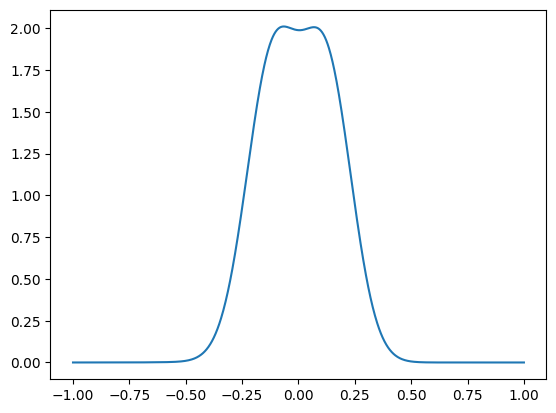

In [16]:
# место для кода
i0 = data['Response'] == 0
kde0 = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(data.loc[i0, 'L1_S24_F1846'].values.reshape(-1, 1))
X_plot = np.linspace(-1, 1, 1000).reshape(-1, 1)
Dens0 = np.exp(kde0.score_samples(X_plot))
plt.plot(X_plot,Dens0)
plt.show()

Ответьте в комментариях на вопрос: является ли выборка хорошо разделимой по признаку  `L1_S24_F1846`?

In [17]:
# место для комментария
# да, потому что расстояние между ближайшими точками, расположенными по разные стороны от нее, является максимальными.


## 2

Разбейте выборку `data` на две равные части: тренировочную `dataTrain` и проверочную `dataTest`. 

In [18]:
dataTrain = data.loc[0:data.shape[0] / 2, ].reset_index(drop=True)
dataTest = data.loc[data.shape[0] / 2:data.shape[0], ].reset_index(drop=True)

Пользуясь кросс-валидацией, подберите **для каждого класса `Response` (`r=0` и `r=1`)** значение ширины ядра `bandwidth`, при котором логарифм правдоподобия максимален на проверочной выборке.

*Help:*

    r = 0
    kde0 = KernelDensity(kernel='gaussian', bandwidth=0.05)
    kde0.fit(dataTrain.loc[dataTrain['Response']==r, 'L1_S24_F1846'].values.reshape(-1, 1))
    logProbability0 = kde0.score_samples(dataTest.loc[dataTest['Response']==r, 'L1_S24_F1846'].values.reshape(-1, 1))
    logProbability0[np.isinf(logProbability0)] = -100 # заменяем -бесконечность
    logLikehood0 = logProbability0.sum()
    print(logLikehood0)

In [19]:
# место для кода
r0 = 0
kde0 = KernelDensity(kernel='gaussian', bandwidth=0.05)
kde0.fit(dataTrain.loc[dataTrain['Response']==r0, 'L1_S24_F1846'].values.reshape(-1, 1))
logProbability0 = kde0.score_samples(dataTest.loc[dataTest['Response']==r0, 'L1_S24_F1846'].values.reshape(-1, 1))
logProbability0[np.isinf(logProbability0)] = -100 # заменяем -бесконечность
logLikehood0 = logProbability0.sum()

r1 = 1
kde1 = KernelDensity(kernel='gaussian', bandwidth=0.05)
kde1.fit(dataTrain.loc[dataTrain['Response']==r1, 'L1_S24_F1846'].values.reshape(-1, 1))
logProbability1 = kde1.score_samples(dataTest.loc[dataTest['Response']==r1, 'L1_S24_F1846'].values.reshape(-1, 1))
logProbability1[np.isinf(logProbability1)] = -100 # заменяем -бесконечность
logLikehood1 = logProbability1.sum()

print(logLikehood0, logLikehood1)

20544.80746112119 103.98787944779147


### 3

Для найденных наилучших `bandwidth` вычислите `p(x|0)` и `p(x|1)` для тестовой выборки. 

In [20]:
predictionProbXafter0 = np.exp(kde0.score_samples(dataTest['L1_S24_F1846'].values.reshape(-1, 1)))
predictionProbXafter1 = np.exp(kde1.score_samples(dataTest['L1_S24_F1846'].values.reshape(-1, 1)))

По формуле Байеса найдите затем `p(0|x)` и `p(1|x)`. Отсортируйте все объекты тестовой выборки по возрастанию предсказанной вероятности `p(1|x)`, выведите на экран вероятности для последних 10 объектов и рассчитайте количество бракованных деталей среди последних 100 объектов в отсортированном ряду.

*Help:*
    
    ind = np.argsort(predictionProb1afterX) - сортировка, возвращающая индексы элементов
    print(predictionProb1afterX[ind[-10:]]) - вывод последних 10 элементов
    print(sum(dataTest.loc[ind[-100:],'Response'])) - количество бракованных среди 100 с максимальной вероятностью брака

In [21]:
# место для кода
ind = np.argsort(predictionProbXafter1) # сортировка, возвращающая индексы элементов
print(predictionProbXafter1[ind[-10:]]) # вывод последних 10 элементов
print(sum(dataTest.loc[ind[-100:],'Response'])) # количество бракованных среди 100 с максимальной вероятностью брака

[2.60911547 2.60911547 2.60911547 2.60911547 2.60911547 2.60911547
 2.60911547 2.60911547 2.60911547 2.60911547]
2
